https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces?select=test.csv


In [1]:
import os
import cv2
from collections import Counter
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from torchvision import transforms
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import kagglehub
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import PyDataset
from tensorflow.keras import layers, models

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\lzx13\.cache\kagglehub\datasets\xhlulu\140k-real-and-fake-faces\versions\2


In [2]:
# ======================================
# Data Configuration
# ======================================
IMG_SIZE = (224, 224)  # Can adjust to 256x256 if needed
BATCH_SIZE = 32
INPUT_SHAPE = (*IMG_SIZE, 3)

# ======================================
# Create Data Generators
# ======================================
# Define paths (MODIFY THESE PATHS IF NEEDED)
TRAIN_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train'
VAL_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/valid'
TEST_DIR = 'C:/Users/lzx13/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test'

# Create base generators with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True  # Explicitly shuffle training data
)

valid_generator = valid_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No shuffle for validation
)

test_generator = valid_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No shuffle for test
)

# Verify class indices
print("\nClass indices:", train_generator.class_indices)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.

Class indices: {'fake': 0, 'real': 1}


In [3]:
# ======================================
# Setup for GPU acceleration using your NVIDIA 4090 GPU
# ======================================
# This code enables CUDA acceleration on available GPUs.
# It sets memory growth to avoid allocating all GPU memory at once.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are set for CUDA acceleration using your NVIDIA 4090 GPU.")
    except RuntimeError as e:
        print(e)

# ======================================
# Define the input shape for the models
# ======================================
# You can adjust INPUT_SHAPE based on your dataset dimensions.
INPUT_SHAPE = (224, 224, 3)

# ======================================
# Example Model 1: Original CNN
# ======================================
def build_cnn_model():
    # Hyperparameters you can adjust:
    # - Number of filters in Conv2D layers (e.g., 32, 64, 128)
    # - Kernel size for convolution layers (e.g., (3,3))
    # - Pooling size in MaxPooling2D layers (e.g., (2,2))
    # - Dropout rate (e.g., 0.5)
    # - Number of units in Dense layers (e.g., 512)
    # - Learning rate for the optimizer (e.g., 0.0001)

    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),  # 32 filters, 3x3 kernel
        MaxPooling2D(2, 2),  # Pool size 2x2

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
        MaxPooling2D(2, 2),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),  # 128 filters, 3x3 kernel
        MaxPooling2D(2, 2),

        Flatten(),  # Flatten the output to feed into dense layers
        Dropout(0.5),  # Dropout layer with rate 0.5 (adjustable to control overfitting)
        Dense(512, activation='relu'),  # Dense layer with 512 units
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Optimizer with adjustable learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust learning rate if necessary

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # Loss function for binary classification
        metrics=['accuracy']  # Metric to monitor performance
    )
    return model

# ======================================
# Model 2: Pretrained ResNet50
# ======================================
def build_resnet_model():
    # Hyperparameters you can adjust:
    # - Choice of pretrained model and its configuration (e.g., ResNet50 with imagenet weights)
    # - Whether to freeze the base model layers or fine-tune them (base_model.trainable)
    # - Number of units in the dense layer after the base model (e.g., 256)
    # - Dropout rate (e.g., 0.5)

    # Load the pretrained ResNet50 model without the top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )

    # Freeze the base model layers to retain pretrained features.
    # Change to "base_model.trainable = True" if you plan to fine-tune.
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),  # Flatten the output from the base model
        Dense(256, activation='relu'),  # Dense layer with 256 units (adjustable)
        Dropout(0.5),  # Dropout layer to reduce overfitting
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Optimizer can be adjusted (e.g., setting a different learning rate)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#========================
#mobilenetv2
#========================
def build_mobilenetv2_model():
    """
    Builds and returns a MobileNetV2-based model for binary classification.
    This function replaces the ResNet50 model with minimal code changes.
    Other parts of the training code remain the same.
    """
    # Load the pretrained MobileNetV2 model with ImageNet weights
    # 'include_top=False' removes the original classification head
    # 'input_shape=INPUT_SHAPE' ensures it matches your data dimensions
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=INPUT_SHAPE
    )

    # Freeze all layers in the base model to retain the pretrained features
    base_model.trainable = False

    # Build a new classification head on top of MobileNetV2
    model = Sequential([
        base_model,
        Flatten(),              # Flatten the feature maps
        Dense(256, activation='relu'),  # Dense layer with 256 units
        Dropout(0.5),          # Dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model using the same hyperparameters as your ResNet code
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [4]:
import csv
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

# ======================================
# test record
# ======================================
class ExperimentLogger(Callback):
    def __init__(self, test_generator, csv_path='training_logs.csv'):
        super().__init__()
        self.test_generator = test_generator
        self.csv_path = csv_path
        self.results = []
        
        self.test_steps = test_generator.samples // test_generator.batch_size

    def on_train_begin(self, logs=None):
        # initialize 
        with open(self.csv_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                'epoch', 'train_loss', 'train_acc',
                'val_loss', 'val_acc', 'test_loss', 'test_acc'
            ])

    def on_epoch_end(self, epoch, logs=None):
        # reset test_geberator
        self.test_generator.reset()
        
        test_loss, test_acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_steps,
            verbose=0
        )
        
        # collect data
        log_data = {
            'epoch': epoch + 1,
            'train_loss': logs.get('loss'),
            'train_acc': logs.get('accuracy'),
            'val_loss': logs.get('val_loss'),
            'val_acc': logs.get('val_accuracy'),
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        self.results.append(log_data)
        
        # write in CSV（four digits）
        with open(self.csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                log_data['epoch'],
                round(log_data['train_loss'], 4),
                round(log_data['train_acc'], 4),
                round(log_data['val_loss'], 4),
                round(log_data['val_acc'], 4),
                round(log_data['test_loss'], 4),
                round(log_data['test_acc'], 4)
            ])
# ======================================
# add logger for training
# ======================================
# initialize model
model = build_mobilenetv2_model()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# create logger
experiment_logger = ExperimentLogger(test_generator, csv_path='resnet_experiment_logs.csv')

# train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=10,
    callbacks=[early_stop, experiment_logger]  # add logger
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


C:\Users\lzx13\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 813s 259ms/step - accuracy: 0.7436 - loss: 0.8579 - val_accuracy: 0.8300 - val_loss: 0.3735
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 855s 274ms/step - accuracy: 0.8349 - loss: 0.3689 - val_accuracy: 0.8500 - val_loss: 0.3435
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 818s 262ms/step - accuracy: 0.8583 - loss: 0.3189 - val_accuracy: 0.8803 - val_loss: 0.2878
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 932s 298ms/step - accuracy: 0.8733 - loss: 0.2823 - val_accuracy: 0.8806 - val_loss: 0.2820
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1062s 340ms/step - accuracy: 0.8834 - loss: 0.2614 - val_accuracy: 0.8905 - val_loss: 0.2790
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 961s 308ms/step - accuracy: 0.8936 - loss: 0.2374 - val_accuracy: 0.8884 - val_loss: 0.2915
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 907s 290ms/step - accuracy: 0.8963 - loss: 0.2266 - val_accuracy: 0.8959 - val_loss: 0.2670
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1020s 327ms/step - accuracy: 0

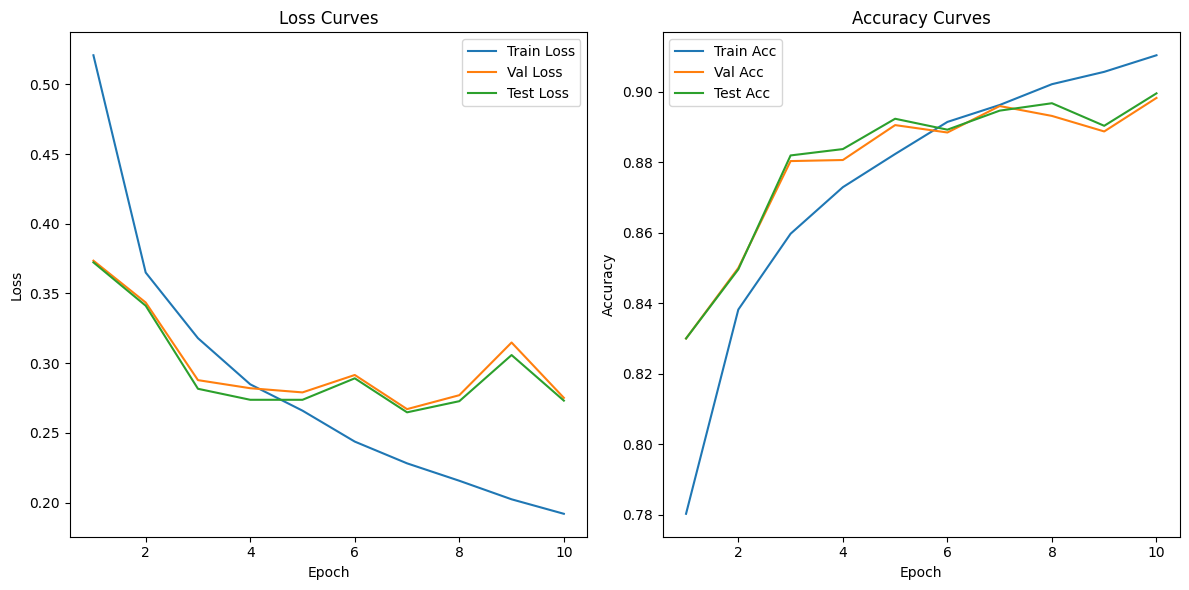

In [6]:
# ======================================
# Visualization Function
# ======================================
def plot_training_curves(csv_path, figsize=(12, 6)):
    # Read CSV data
    import pandas as pd
    df = pd.read_csv(csv_path)

    # Create plots
    plt.figure(figsize=figsize)

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
    plt.plot(df['epoch'], df['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train_acc'], label='Train Acc')
    plt.plot(df['epoch'], df['val_acc'], label='Val Acc')
    plt.plot(df['epoch'], df['test_acc'], label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.savefig('mobilenetv2_training_curves.png') 
    plt.show()

# 生成图表
plot_training_curves('resnet_experiment_logs.csv')